In [10]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from gpjax import Dataset
from gpjax.gps import Prior as GPPrior
from gpjax.kernels.approximations import RFF
from gpjax.kernels import RBF

from uncprop.utils.gpjax_models import construct_gp, train_gp_hyperpars

key = jr.key(32532)

In [2]:
# latent function
f = lambda x: jnp.sin(x) + 0.3 * jnp.cos(10*x)

# design data
x = jnp.linspace(0, 10, 5).reshape(-1, 1)
xgrid = jnp.linspace(0, 10, 100).reshape(-1, 1)

y = f(x)
ygrid = f(xgrid)

design = Dataset(x, y)
testdata = Dataset(xgrid, ygrid)

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/gpjax/dataset.py:43: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/gpjax/dataset.py:43: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


In [3]:
def plot_gp(gp, design, testdata):
    fig, ax = plt.subplots()
    xgrid = testdata.X
    ygrid = testdata.y.ravel()
    x = design.X
    y = design.y.ravel()

    pred = gp(xgrid, train_data=design)
    m = pred.mean.ravel()
    sd = jnp.sqrt(pred.variance).ravel()

    ax.plot(xgrid.ravel(), ygrid, 'black')
    ax.plot(x.ravel(), y, 'ro')
    ax.plot(xgrid.ravel(), m, 'blue')
    ax.fill_between(xgrid.ravel(), m-2*sd, m+2*sd, color='lightblue', alpha=0.4)

    return fig, ax


In [17]:
gp_untuned, bijection = construct_gp(design, set_bounds=True)
gp, opt_info = train_gp_hyperpars(gp_untuned, bijection, design)

key, rff_key = jr.split(key)
rff_kernel = RFF(base_kernel=gp.prior.kernel, num_basis_fns=300, key=rff_key)
rff_gp = gp.likelihood * GPPrior(mean_function=gp.prior.mean_function, kernel=rff_kernel)

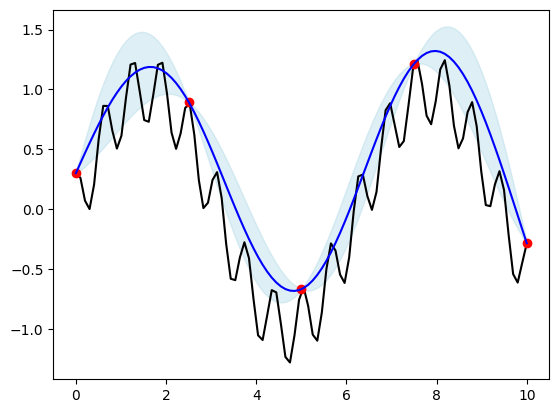

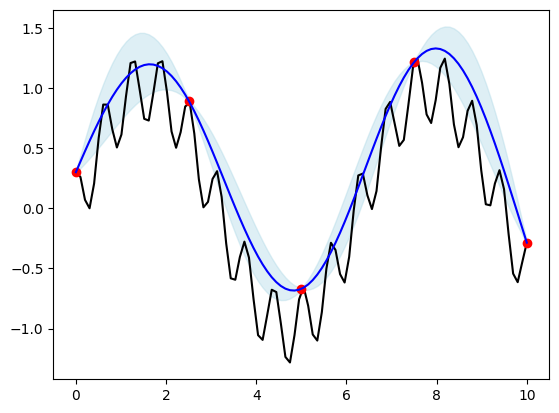

In [5]:
fig_exact, ax_exact = plot_gp(gp, design, testdata)
fig_rff, ax_rff = plot_gp(rff_gp, design, testdata)

In [18]:
# sampling trajectories
traj = gp.sample_approx(num_samples=10, train_data=design, num_features=300, key=rff_key)



In [21]:
test = traj(testdata.X)

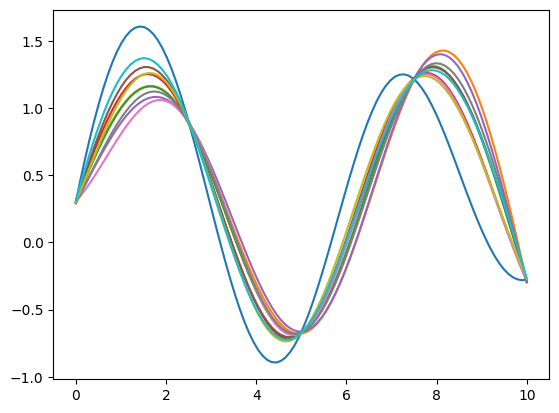

In [24]:
plt.plot(testdata.X.ravel(), test)